
# 📙 Lecture 8 — Feature Scaling & Engineering (Colab Notebook)
_Auto-generated: 2025-08-20 06:39_

This notebook includes:
- **Theory recap**: Min–Max vs Z-score scaling, when to scale
- **Project (with solutions)**: Scale `Age`, `Fare`; engineer `FamilySize`, `IsAlone`, `FarePerPerson`
- **Visuals**: Histograms & boxplots (matplotlib)
- **Distance effect demo**: Scaling impact on Euclidean distance & KNN
- **Discussion**: Model-aware **answers**
- **Homework**: Propose 3 features & implement 1 — **with solution & tests**


## ⚙️ Setup

In [1]:

# If in Colab and packages are missing, you can uncomment installs:
# !pip install -q pandas numpy scikit-learn joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import joblib
import io, urllib.request

pd.set_option('display.max_columns', None)
print('pandas:', pd.__version__)


pandas: 2.3.0


## 🚢 Load Titanic Dataset

In [4]:

# # Try to fetch seaborn's Titanic CSV; fallback to synthetic data if offline.
# try:
#     url = 'https://raw.githubusercontent.com/mwaskom/seaborn-data/master/titanic.csv'
#     df = pd.read_csv(url)
#     print("Loaded Titanic from seaborn-data GitHub.")
# except Exception as e:
#     rng = np.random.default_rng(8)
#     n = 400
#     df = pd.DataFrame({
#         'survived': rng.integers(0,2,size=n),
#         'pclass': rng.choice([1,2,3], size=n, p=[0.24,0.21,0.55]),
#         'sex': rng.choice(['male','female'], size=n, p=[0.62,0.38]),
#         'age': np.clip(rng.normal(30, 14, n), 0, None),
#         'sibsp': rng.integers(0,5,size=n),
#         'parch': rng.integers(0,5,size=n),
#         'fare': np.abs(rng.normal(32, 35, n)),
#         'embarked': rng.choice(['C','Q','S', np.nan], size=n, p=[0.18,0.09,0.68,0.05])
#     })
#     print("Using synthetic Titanic-like data due to network limits.", e)

# Persist a CSV for reproducibility
df = pd.read_csv('../Data/titanic.csv')
print("Saved titanic.csv | Shape:", df.shape)
df.head()


Saved titanic.csv | Shape: (891, 15)


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True



## 🧠 Theory Recap
**Min–Max Scaling**  
\[ x' = \frac{x - x_{min}}{x_{max} - x_{min}} \] → maps to **[0,1]**.

**Z-score Standardization**  
\[ z = \frac{x - \mu}{\sigma} \] → **mean 0**, **std 1**.

**When to scale**  
- Distance-based: **KNN**, **K-means**, **SVM**, **Neural Nets** → **scale**  
- Tree-based: **Decision Trees/Random Forest/GBDT** → usually **no scaling needed**


## 🛠 Project Step 1 — Scale `Age` & `Fare` (Min–Max and Z-score)

In [5]:

work = df.copy()

# Minimal imputations for demo (median for age/fare if missing)
for col in ['age','fare']:
    if work[col].isna().any():
        work[col] = work[col].fillna(work[col].median())

minmax = MinMaxScaler()
zscaler = StandardScaler()

work['age_minmax']  = minmax.fit_transform(work[['age']])
work['fare_minmax'] = minmax.fit_transform(work[['fare']])

work['age_z']  = zscaler.fit_transform(work[['age']])
work['fare_z'] = zscaler.fit_transform(work[['fare']])

work[['age','age_minmax','age_z','fare','fare_minmax','fare_z']].head(10)


,age,age_minmax,age_z,fare,fare_minmax,fare_z
0,22.0,0.271174,-0.565736,7.2500,0.014151,-0.502445
1,38.0,0.472229,0.663861,71.2833,0.139136,0.786845
2,26.0,0.321438,-0.258337,7.9250,0.015469,-0.488854
3,35.0,0.434531,0.433312,53.1000,0.103644,0.420730
4,35.0,0.434531,0.433312,8.0500,0.015713,-0.486337
5,28.0,0.346569,-0.104637,8.4583,0.016510,-0.478116
6,54.0,0.673285,1.893459,51.8625,0.101229,0.395814
7,2.0,0.019854,-2.102733,21.0750,0.041136,-0.224083
8,27.0,0.334004,-0.181487,11.1333,0.021731,-0.424256
9,14.0,0.170646,-1.180535,30.0708,0.058694,-0.042956


### 📊 Visuals — Before vs After Scaling (matplotlib)

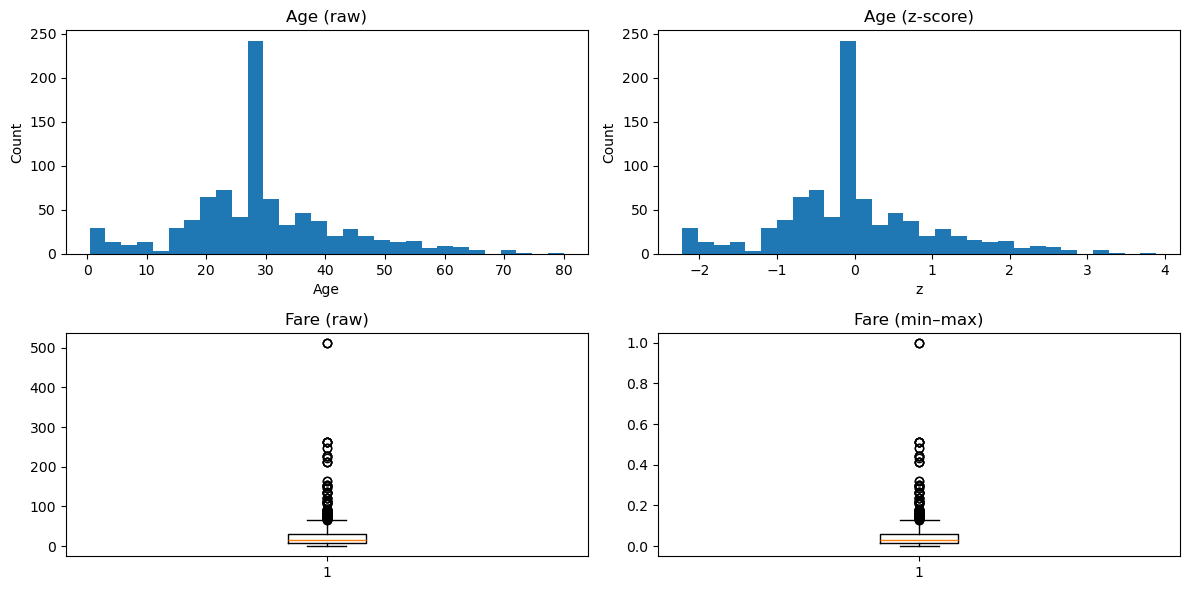

In [6]:

fig = plt.figure(figsize=(12,6))

# Age histograms
ax1 = fig.add_subplot(2,2,1); ax1.hist(work['age'], bins=30)
ax1.set_title('Age (raw)'); ax1.set_xlabel('Age'); ax1.set_ylabel('Count')
ax2 = fig.add_subplot(2,2,2); ax2.hist(work['age_z'], bins=30)
ax2.set_title('Age (z-score)'); ax2.set_xlabel('z'); ax2.set_ylabel('Count')

# Fare boxplots
ax3 = fig.add_subplot(2,2,3); ax3.boxplot(work['fare'].values, vert=True, showfliers=True); ax3.set_title('Fare (raw)')
ax4 = fig.add_subplot(2,2,4); ax4.boxplot(work['fare_minmax'].values, vert=True, showfliers=True); ax4.set_title('Fare (min–max)')

plt.tight_layout(); plt.show()


## 🛠 Project Step 2 — Feature Engineering (`FamilySize`, `IsAlone`, `FarePerPerson`)

In [7]:

work['FamilySize'] = work['sibsp'].fillna(0) + work['parch'].fillna(0) + 1
work['IsAlone'] = (work['FamilySize'] == 1).astype(int)

# Avoid divide-by-zero (FamilySize >=1 by construction)
work['FarePerPerson'] = work['fare'] / work['FamilySize']

work[['sibsp','parch','FamilySize','IsAlone','fare','FarePerPerson']].head(10)


,sibsp,parch,FamilySize,IsAlone,fare,FarePerPerson
0,1,0,2,0,7.2500,3.62500
1,1,0,2,0,71.2833,35.64165
2,0,0,1,1,7.9250,7.92500
3,1,0,2,0,53.1000,26.55000
4,0,0,1,1,8.0500,8.05000
5,0,0,1,1,8.4583,8.45830
6,0,0,1,1,51.8625,51.86250
7,3,1,5,0,21.0750,4.21500
8,0,2,3,0,11.1333,3.71110
9,1,0,2,0,30.0708,15.03540


### 📈 Visuals — Engineered Features

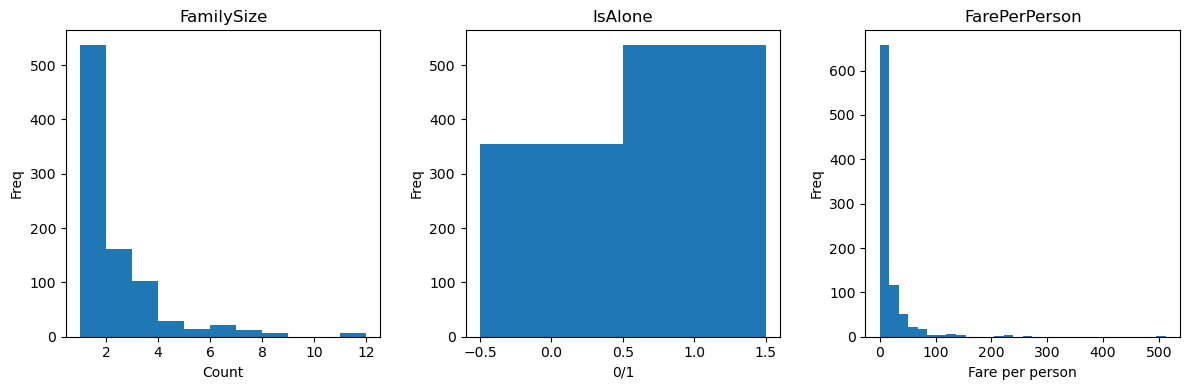

In [8]:

fig = plt.figure(figsize=(12,4))

ax1 = fig.add_subplot(1,3,1); ax1.hist(work['FamilySize'], bins=range(1,int(work['FamilySize'].max())+2))
ax1.set_title('FamilySize'); ax1.set_xlabel('Count'); ax1.set_ylabel('Freq')

ax2 = fig.add_subplot(1,3,2); ax2.hist(work['IsAlone'], bins=[-0.5,0.5,1.5])
ax2.set_title('IsAlone'); ax2.set_xlabel('0/1'); ax2.set_ylabel('Freq')

ax3 = fig.add_subplot(1,3,3); ax3.hist(work['FarePerPerson'], bins=30)
ax3.set_title('FarePerPerson'); ax3.set_xlabel('Fare per person'); ax3.set_ylabel('Freq')

plt.tight_layout(); plt.show()


## 🧪 Scaling Effect on Distance (Euclidean) & KNN

In [9]:

# Prepare a tiny two-feature set to illustrate distance dominance by 'fare' before scaling.
tmp = work[['age','fare']].copy()

# pick two random passengers for pairwise distance comparison
i, j = 0, 1
d_raw = np.sqrt((tmp.iloc[i]['age']-tmp.iloc[j]['age'])**2 + (tmp.iloc[i]['fare']-tmp.iloc[j]['fare'])**2)

# scale with z-score
sc = StandardScaler()
tmp_scaled = pd.DataFrame(sc.fit_transform(tmp), columns=['age','fare'])
d_scaled = np.sqrt((tmp_scaled.iloc[i]['age']-tmp_scaled.iloc[j]['age'])**2 + (tmp_scaled.iloc[i]['fare']-tmp_scaled.iloc[j]['fare'])**2)

print("Raw distance:", round(d_raw,3), " | Scaled distance:", round(d_scaled,3))

# Simple KNN demo for sensitivity
# Encode 'sex' to numeric for a minimal feature set; fill small missingness
knn_df = work.copy()
if knn_df['sex'].isna().any():
    knn_df['sex'] = knn_df['sex'].fillna(knn_df['sex'].mode().iloc[0])
le = LabelEncoder()
knn_df['sex_enc'] = le.fit_transform(knn_df['sex'])

X_raw = knn_df[['age','fare','sex_enc']].copy()
y = knn_df['survived'] if 'survived' in knn_df.columns else (knn_df['IsAlone'] ^ (knn_df['pclass'] == 1))

# Train/test split
X_tr, X_te, y_tr, y_te = train_test_split(X_raw, y, test_size=0.3, random_state=42, stratify=y)

# KNN on raw features
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_tr, y_tr)
acc_raw = accuracy_score(y_te, knn.predict(X_te))

# KNN on scaled features (z-score)
sc2 = StandardScaler()
X_tr_s = sc2.fit_transform(X_tr)
X_te_s = sc2.transform(X_te)
knn_s = KNeighborsClassifier(n_neighbors=7)
knn_s.fit(X_tr_s, y_tr)
acc_scaled = accuracy_score(y_te, knn_s.predict(X_te_s))

print("KNN accuracy — raw:", round(acc_raw,3), " | scaled:", round(acc_scaled,3))


Raw distance: 66.002  | Scaled distance: 1.782
KNN accuracy — raw: 0.683  | scaled: 0.784



## 💬 Discussion — With Answers
**Q1. Which engineered feature has the strongest causal plausibility?**  
**A.** On Titanic, **FamilySize** and **IsAlone** are compelling: traveling with family could influence access to lifeboats or movement on the ship (crowding / coordination). **FarePerPerson** proxies socioeconomic status and cabin access (lifeboat proximity), but its causal path is more indirect (confounded by `pclass`).

**Q2. Should we scale categorical encodings?**  
**A.** One-hot columns are **0/1**; scaling is unnecessary and sometimes harmful for interpretability. If you use **target or ordinal encodings**, scaling may be reasonable depending on the downstream model.


## 🏠 Homework — Propose 3 Features; Implement 1 with Tests (Solution Included)

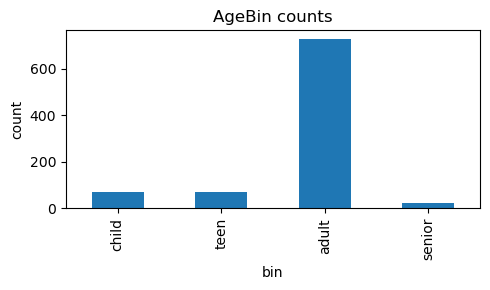

,age,AgeBin
0,22.0,adult
1,38.0,adult
2,26.0,adult
3,35.0,adult
4,35.0,adult
5,28.0,adult
6,54.0,adult
7,2.0,child
8,27.0,adult
9,14.0,teen


In [10]:

# Proposed features (example):
# 1) AgeBin (ordinal bins): child/teen/adult/senior
# 2) Deck from Cabin (if available): extract first letter, then one-hot
# 3) TicketGroupSize: passengers sharing the same ticket (proxy for group travel)

sol = work.copy()

# Implement 1: AgeBin (with tests)
bins = [-0.01, 12, 18, 60, np.inf]
labels = ['child','teen','adult','senior']
sol['AgeBin'] = pd.cut(sol['age'], bins=bins, labels=labels, right=True)

# Tests
assert not sol['AgeBin'].isna().any(), "AgeBin has missing values"
assert set(sol['AgeBin'].unique()) <= set(labels), "Unexpected AgeBin labels"

# Distribution check (matplotlib)
counts = sol['AgeBin'].value_counts().reindex(labels)
fig = plt.figure(figsize=(5,3))
ax = fig.add_subplot(1,1,1)
counts.plot(kind='bar', ax=ax)
ax.set_title('AgeBin counts'); ax.set_xlabel('bin'); ax.set_ylabel('count')
plt.tight_layout(); plt.show()

sol[['age','AgeBin']].head(10)


In [12]:
df["Deck"] = df["deck"].dropna().apply(lambda x: str(x)[0])   # take first letter
deck_ohe = pd.get_dummies(df["Deck"], prefix="Deck", drop_first=True)
df = pd.concat([df.drop(columns=["deck", "Deck"]), deck_ohe], axis=1)

In [14]:
#no ticket attribute

In [15]:
df.head(10)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,embark_town,alive,alone,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,Southampton,no,False,False,False,False,False,False,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,Cherbourg,yes,False,False,True,False,False,False,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,Southampton,yes,True,False,False,False,False,False,False
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,Southampton,yes,False,False,True,False,False,False,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,Southampton,no,True,False,False,False,False,False,False
5,0,3,male,NaN,0,0,8.4583,Q,Third,man,True,Queenstown,no,True,False,False,False,False,False,False
6,0,1,male,54.0,0,0,51.8625,S,First,man,True,Southampton,no,True,False,False,False,True,False,False
7,0,3,male,2.0,3,1,21.0750,S,Third,child,False,Southampton,no,False,False,False,False,False,False,False
8,1,3,female,27.0,0,2,11.1333,S,Third,woman,False,Southampton,yes,False,False,False,False,False,False,False
9,1,2,female,14.0,1,0,30.0708,C,Second,child,False,Cherbourg,yes,False,False,False,False,False,False,False


## 💾 Save Artifacts

In [ ]:

work.to_csv('lecture8_engineered_scaled.csv', index=False)
joblib.dump(minmax, 'minmax_scaler_agefare.pkl')
joblib.dump(StandardScaler().fit(df[['age','fare']].fillna(df[['age','fare']].median())), 'zscaler_agefare.pkl')
print("Saved: lecture8_engineered_scaled.csv, minmax_scaler_agefare.pkl, zscaler_agefare.pkl")



## ✅ Wrap-up Checklist
- [x] Scaled **Age, Fare** using **Min–Max** and **Z-score**
- [x] Created **FamilySize, IsAlone, FarePerPerson**
- [x] Visualized **before/after** with histograms & boxplots
- [x] Demonstrated **distance/KNN** sensitivity to scaling
- [x] Answered discussion prompts
- [x] Implemented homework feature with tests
